In [1]:
import numpy as np
import pandas as pd

In [2]:
hours = np.array([0.5, 0.75, 1., 1.25, 1.5, 1.75, 1.75, 2.,
 2.25, 2.5, 2.75, 3., 3.25, 3.5, 4., 4.25,
 4.5, 4.75, 5., 5.5])
success = np.array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
 0, 1, 1, 1, 1, 1, 1])

In [20]:
d=pd.DataFrame({'hours':hours,'success':success})

In [22]:
d.head()

,hours,success
0,0.50,0
1,0.75,0
2,1.00,0
3,1.25,0
4,1.50,0


In [23]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   hours    20 non-null     float64
 1   success  20 non-null     int32  
dtypes: float64(1), int32(1)
memory usage: 368.0 bytes


In [24]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier(hidden_layer_sizes=[32],max_iter=1000,random_state=100)


In [29]:
model.fit(d.hours.values.reshape(-1,1),d.success)

MLPClassifier(hidden_layer_sizes=[32], max_iter=1000, random_state=100)

In [30]:
model


MLPClassifier(hidden_layer_sizes=[32], max_iter=1000, random_state=100)

In [31]:
d['prediction']=model.predict(d.hours.values.reshape(-1,1))

In [32]:
d.tail()

,hours,success,prediction
15,4.25,1,1
16,4.50,1,1
17,4.75,1,1
18,5.00,1,1
19,5.50,1,1


<AxesSubplot:xlabel='hours'>

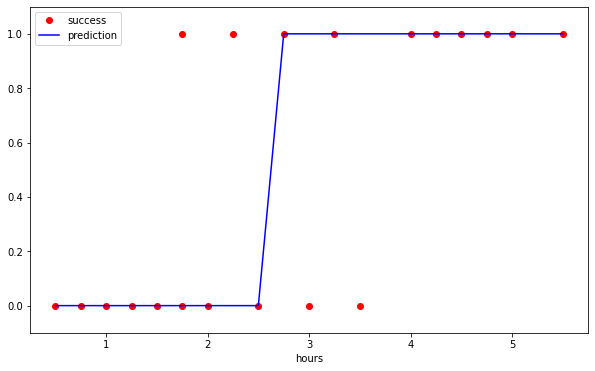

In [33]:
d.plot(x='hours',y=['success','prediction'],style=['ro','b-'],ylim=[-0.1,1.1],figsize=(10,6))

In [277]:
raw=pd.read_csv('aiif_eikon_eod_data.csv',parse_dates=True,index_col=0)
data=pd.DataFrame(raw['EUR='])

In [278]:
data.rename(columns={'EUR=':'price'},inplace=True)

In [279]:
data.head()

,price
Date,
2010-01-01,1.4323
2010-01-04,1.4411
2010-01-05,1.4368
2010-01-06,1.4412
2010-01-07,1.4318


In [280]:
data['return']=np.log(data.price/data.price.shift(1))


In [281]:
data['direction']=np.where(data['return']>0,1,0)

In [282]:
lags=5

In [283]:
col=[]
for lag in range(1,lags+1):
    s=f"lag_{lag}"
    col.append(s)
    data[s]=data['return'].shift(lag)

data.dropna(inplace=True)

In [284]:
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5
Date,,,,,,,,
2019-12-26,1.1096,0.0005,1,0.0003,0.0001,0.0007,-0.0038,0.0008
2019-12-27,1.1175,0.0071,1,0.0005,0.0003,0.0001,0.0007,-0.0038
2019-12-30,1.1197,0.0020,1,0.0071,0.0005,0.0003,0.0001,0.0007
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0005,0.0003,0.0001
2020-01-01,1.1210,0.0000,0,0.0012,0.0020,0.0071,0.0005,0.0003


In [285]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,RMSprop
import random
def setseeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

In [286]:
optimizer=Adam(learning_rate=0.0001)

In [287]:
setseeds()

In [288]:
model=Sequential()

In [289]:
model = Sequential() 
model.add(Dense(64, activation='relu',
 input_shape=(lags,))) 
model.add(Dense(64, activation='relu')) 
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
 loss='binary_crossentropy',
 metrics=['accuracy'])

In [290]:
cutoff='2017-12-31'

In [264]:
training_data=data[data.index<cutoff].copy()

In [291]:
mu,std=training_data.mean(),training_data.std()
mu,std

(price        1.250453
 return      -0.000088
 direction    0.501442
 lag_1       -0.000087
 lag_2       -0.000093
 lag_3       -0.000092
 lag_4       -0.000093
 lag_5       -0.000091
 dtype: float64,
 price        0.116302
 return       0.005889
 direction    0.500118
 lag_1        0.005890
 lag_2        0.005891
 lag_3        0.005891
 lag_4        0.005891
 lag_5        0.005893
 dtype: float64)

In [293]:
training_data_=(training_data-mu)/std

In [294]:
test_data=data[data.index>=cutoff].copy()

In [295]:
test_data_=(test_data-mu)/std

In [296]:
%%time
model.fit(training_data[col],
         training_data['direction'],epochs=50,verbose=False,validation_split=0.2,shuffle=False)

Wall time: 6.18 s


In [330]:
res=pd.DataFrame(model.history.history)
res.head()

""


<AxesSubplot:title={'center':'accuctracy of the DNN classifier'}>

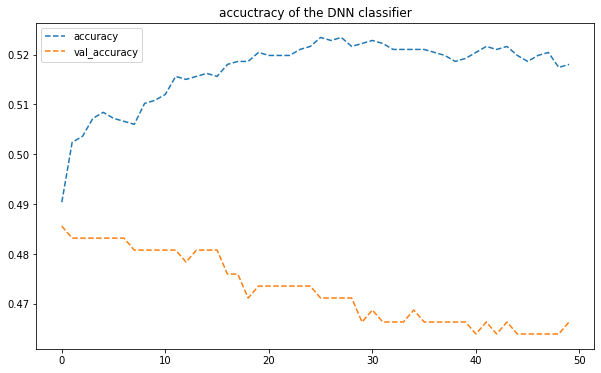

In [300]:
res[['accuracy','val_accuracy']].plot(figsize=(10,6),style='--',title="accuctracy of the DNN classifier")

In [301]:
model.evaluate(training_data_[col],training_data['direction'])

65/65 [==============================] - 0s 2ms/step - loss: 0.7770 - accuracy: 0.5226


[0.7769842743873596, 0.5225961804389954]

In [303]:
pred=np.where(model.predict(training_data_[col])>0.5,1,0)

65/65 [==============================] - 0s 2ms/step


In [305]:
pred[:30].flatten()

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0])

In [306]:
training_data['prediction']=np.where(pred>0,1,-1)

In [308]:
training_data['strategy']=(training_data['prediction']*training_data['return'])
training_data[['return','strategy']].sum().apply(np.exp)

return      0.832362
strategy    1.453705
dtype: float64

<AxesSubplot:xlabel='Date'>

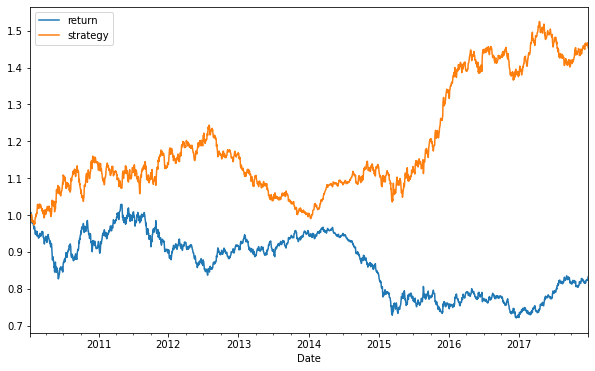

In [309]:
training_data[['return','strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [310]:
model.evaluate(test_data_[col],test_data['direction'])

17/17 [==============================] - 0s 3ms/step - loss: 0.7443 - accuracy: 0.5201


[0.7443056702613831, 0.5200764536857605]

In [311]:
pred=np.where(model.predict(test_data_[col])>0.5,1,0)

17/17 [==============================] - 0s 2ms/step


In [312]:
test_data['prediction']=np.where(pred>0,1,-1)

In [313]:
test_data.prediction.value_counts()

-1    322
 1    201
Name: prediction, dtype: int64

In [314]:
test_data['strategy']=test_data['prediction']*test_data['return']

In [315]:
test_data[['return','strategy']].sum().apply(np.exp)

return      0.934478
strategy    1.086467
dtype: float64

<AxesSubplot:xlabel='Date'>

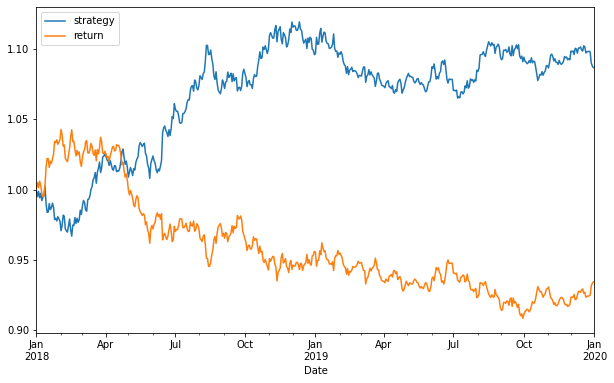

In [316]:
test_data[['strategy','return']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [378]:
data

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2010-03-22,1.3555,0.001772,1,-0.005528,-0.009582,-0.002327,0.006997,-0.006415,-0.003371,0.005262,-0.030572
2010-03-23,1.3498,-0.004214,0,0.001772,-0.005528,-0.009582,-0.002327,0.006997,-0.001734,0.005276,-0.026256
2010-03-24,1.3313,-0.013801,0,-0.004214,0.001772,-0.005528,-0.009582,-0.002327,-0.003976,0.005135,-0.029964
2010-03-25,1.3278,-0.002632,0,-0.013801,-0.004214,0.001772,-0.005528,-0.009582,-0.006270,0.005960,-0.046070
2010-03-26,1.3410,0.009892,1,-0.002632,-0.013801,-0.004214,0.001772,-0.005528,-0.004880,0.005940,-0.047122
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-26,1.1096,0.000541,1,0.000271,0.000090,0.000722,-0.003784,0.000810,-0.000378,0.002319,0.000748
2019-12-27,1.1175,0.007094,1,0.000541,0.000271,0.000090,0.000722,-0.003784,-0.000432,0.002317,0.001400
2019-12-30,1.1197,0.001967,1,0.007094,0.000541,0.000271,0.000090,0.000722,0.001744,0.002759,0.009288


In [379]:
data['momentum']=data['return'].rolling(5).mean().shift(1)
data.head()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2010-03-22,1.3555,0.001772,1,-0.005528,-0.009582,-0.002327,0.006997,-0.006415,NaN,0.005262,-0.030572
2010-03-23,1.3498,-0.004214,0,0.001772,-0.005528,-0.009582,-0.002327,0.006997,NaN,0.005276,-0.026256
2010-03-24,1.3313,-0.013801,0,-0.004214,0.001772,-0.005528,-0.009582,-0.002327,NaN,0.005135,-0.029964
2010-03-25,1.3278,-0.002632,0,-0.013801,-0.004214,0.001772,-0.005528,-0.009582,NaN,0.005960,-0.046070
2010-03-26,1.3410,0.009892,1,-0.002632,-0.013801,-0.004214,0.001772,-0.005528,NaN,0.005940,-0.047122


In [380]:
data['volatility']=data['return'].rolling(20).std().shift(1)
data['distance']=(data['price']-data['price'].rolling(50).mean()).shift(1)

In [381]:
data.dropna(inplace=True)

In [382]:
data.head()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2010-05-31,1.2305,0.003093,1,-0.008200,0.016385,-0.016143,0.001133,-0.017576,-0.004880,0.011307,-0.080680
2010-06-01,1.2225,-0.006523,0,0.003093,-0.008200,0.016385,-0.016143,0.001133,-0.000746,0.011378,-0.074380
2010-06-02,1.2249,0.001961,1,-0.006523,0.003093,-0.008200,0.016385,-0.016143,-0.002277,0.011009,-0.079834
2010-06-03,1.2157,-0.007539,0,0.001961,-0.006523,0.003093,-0.008200,0.016385,0.001343,0.010798,-0.075306
2010-06-04,1.1973,-0.015251,0,-0.007539,0.001961,-0.006523,0.003093,-0.008200,-0.003441,0.010618,-0.082264


In [383]:
col=['lag_1','lag_2','lag_3','lag_4','lag_5','momentum','volatility','distance']

In [384]:
data.round(4).tail()

,price,return,direction,lag_1,lag_2,lag_3,lag_4,lag_5,momentum,volatility,distance
Date,,,,,,,,,,,
2019-12-26,1.1096,0.0005,1,0.0003,0.0001,0.0007,-0.0038,0.0008,-0.0004,0.0023,0.0007
2019-12-27,1.1175,0.0071,1,0.0005,0.0003,0.0001,0.0007,-0.0038,-0.0004,0.0023,0.0014
2019-12-30,1.1197,0.0020,1,0.0071,0.0005,0.0003,0.0001,0.0007,0.0017,0.0028,0.0093
2019-12-31,1.1210,0.0012,1,0.0020,0.0071,0.0005,0.0003,0.0001,0.0020,0.0025,0.0114
2020-01-01,1.1210,0.0000,0,0.0012,0.0020,0.0071,0.0005,0.0003,0.0022,0.0025,0.0125


In [385]:
training_data=data[data.index<cutoff].copy()

In [386]:
training_data_=(training_data-training_data.mean())/training_data.std()

In [387]:
test_data=data[data.index>=cutoff].copy()

In [388]:
test_data_=(test_data-test_data.mean())/test_data.mean()

In [389]:
setseeds()

In [390]:
model=Sequential()

In [391]:
model.add(Dense(32,activation='relu',input_shape=(len(col),)))

In [392]:
model.add(Dense(32,activation='relu'))

In [393]:
model.add(Dense(1,activation='sigmoid'))

In [394]:
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [395]:
%%time
model.fit(training_data[col],training_data['direction'],verbose=False,epochs=25)

Wall time: 2.84 s


In [396]:
model.evaluate(training_data_[col],training_data['direction'])

62/62 [==============================] - 0s 2ms/step - loss: 0.7110 - accuracy: 0.5242


[0.710976779460907, 0.5242424011230469]

In [397]:
pred=np.where(model.predict(training_data_[col])>0.5,1,0)

62/62 [==============================] - 0s 1ms/step


In [398]:
training_data['prediction']=np.where(pred>0,1,-1)

In [399]:
training_data['strategy']=training_data['prediction']*training_data['return']

In [400]:
training_data[['return','strategy']].sum().apply(np.exp)

return      0.977908
strategy    1.522283
dtype: float64

<AxesSubplot:xlabel='Date'>

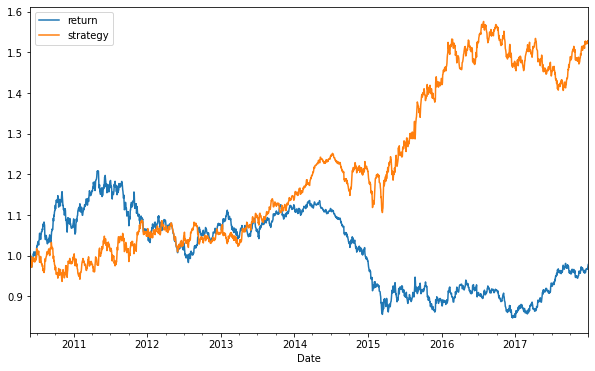

In [401]:
training_data[['return','strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))

In [402]:
model.evaluate(test_data_[col],test_data['direction'])

17/17 [==============================] - 0s 2ms/step - loss: 3.4936 - accuracy: 0.4723


[3.493593692779541, 0.47227534651756287]

In [403]:
pred=np.where(model.predict(test_data_[col])>0.5,1,0)

17/17 [==============================] - 0s 2ms/step


In [404]:
test_data['prediction']=np.where(pred>0,1,-1)

In [405]:
test_data['prediction'].value_counts()

 1    288
-1    235
Name: prediction, dtype: int64

In [406]:
test_data['strategy']=test_data['return']*test_data['prediction']

In [407]:
test_data[['return','strategy']].sum().apply(np.exp)

return      0.934478
strategy    0.875842
dtype: float64

<AxesSubplot:xlabel='Date'>

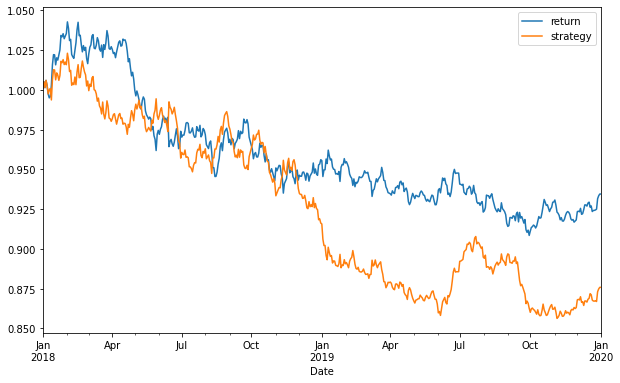

In [408]:
test_data[['return','strategy']].cumsum().apply(np.exp).plot(figsize=(10,6))